In [2]:
!pip install -U tensorflow


  Using cached tensorflow-2.10.0-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (578.1 MB)
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
  Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)
  Using cached absl_py-1.3.0-py3-none-any.whl (124 kB)
  Using cached keras-2.10.0-py2.py3-none-any.whl (1.7 MB)
  Using cached protobuf-3.19.6-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.1 MB)
  Using cached gast-0.4.0-py3-none-any.whl (9.8 kB)
  Using cached tensorflow_estimator-2.10.0-py2.py3-none-any.whl (438 kB)
  Using cached tensorflow_io_gcs_filesystem-0.27.0-cp39-cp39-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (2.4 MB)
  Using cached flatbuffers-22.10.26-py2.py3-none-any.whl (26 kB)
  Using cached libclang-14.0.6-py2.py3-none-manylinux2010_x86_64.whl (14.1 MB)
  Using cached tensorboard-2.10.1-py3-none-any.whl (5.9 MB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Using cached termcolor-2.1.0-py3-none-any.whl (5.8 kB)
  Using c

In [3]:
import intake
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from glob import glob

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import *
from tensorflow.keras import Sequential
from utils import * 

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

plt.rcParams['savefig.dpi'] = 400
plt.rcParams['font.size'] = 13
plt.rcParams["legend.frameon"] = False

2022-11-09 15:37:12.384912: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-09 15:37:12.551909: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-09 15:37:12.551939: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-11-09 15:37:12.588705: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-09 15:37:13.478980: W tensorflow/stream_executor/platform/de

In [40]:
cwd = os.getcwd()

train_path = os.path.join(cwd,'Data','train_val')
test_path  = os.path.join(cwd,'Data','test')

make_dir(train_path)
make_dir(test_path)

In [41]:
ds_forcing = xr.open_dataset('timeseries_edc-wdc_temp.nc',decode_times=False)

In [42]:
cat = intake.open_catalog('https://raw.githubusercontent.com/ldeo-glaciology/pangeo-pismpaleo/main/paleopism.yaml')


In [43]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:33601")
client

<Client: 'tcp://127.0.0.1:33601' processes=4 threads=16, memory=58.88 GiB>

In [44]:
snapshots = cat["snapshots1ka"].to_dask()

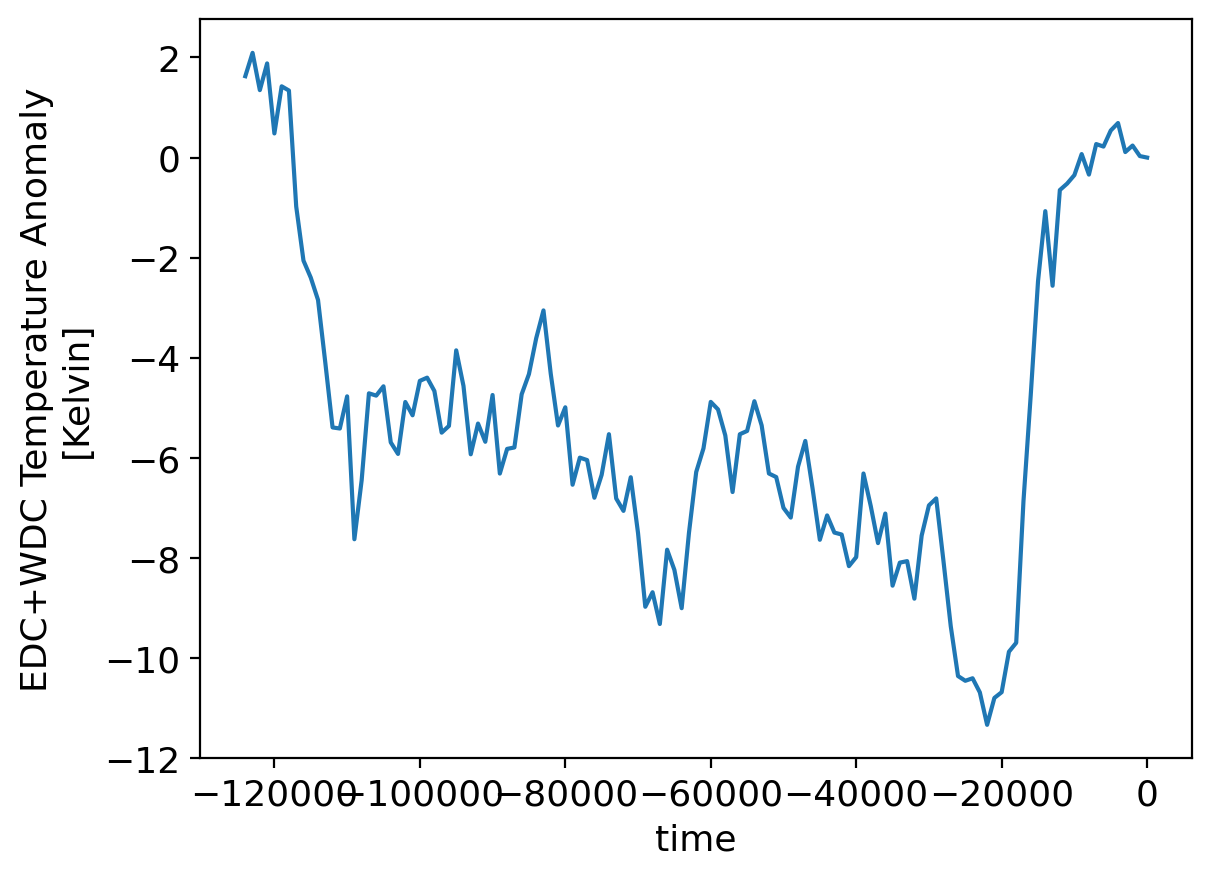

In [45]:
ds_forcing_interp = ds_forcing.interp(time=snapshots.time)
ds_forcing_interp.delta_T.plot()

In [46]:
ds_forcing_interp.delta_T.coords['time'].data

array([-124000., -123000., -122000., -121000., -120000., -119000.,
       -118000., -117000., -116000., -115000., -114000., -113000.,
       -112000., -111000., -110000., -109000., -108000., -107000.,
       -106000., -105000., -104000., -103000., -102000., -101000.,
       -100000.,  -99000.,  -98000.,  -97000.,  -96000.,  -95000.,
        -94000.,  -93000.,  -92000.,  -91000.,  -90000.,  -89000.,
        -88000.,  -87000.,  -86000.,  -85000.,  -84000.,  -83000.,
        -82000.,  -81000.,  -80000.,  -79000.,  -78000.,  -77000.,
        -76000.,  -75000.,  -74000.,  -73000.,  -72000.,  -71000.,
        -70000.,  -69000.,  -68000.,  -67000.,  -66000.,  -65000.,
        -64000.,  -63000.,  -62000.,  -61000.,  -60000.,  -59000.,
        -58000.,  -57000.,  -56000.,  -55000.,  -54000.,  -53000.,
        -52000.,  -51000.,  -50000.,  -49000.,  -48000.,  -47000.,
        -46000.,  -45000.,  -44000.,  -43000.,  -42000.,  -41000.,
        -40000.,  -39000.,  -38000.,  -37000.,  -36000.,  -350

In [47]:
X_df = pd.DataFrame({"delta_T": ds_forcing_interp.delta_T.data},index=ds_forcing_interp.delta_T.coords['time'].data)

First let's test by training on one ensemble member (will be overfit)

In [48]:
y_array = snapshots.velbar_mag.isel(par_esia=0,par_ppq=0,par_prec=0,par_visc=0).load()

In [49]:
y_array

<xarray.DataArray 'velbar_mag' (time: 125, y: 381, x: 381)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
    par_esia  float64 1.0
    par_ppq   float64 0.25
    par_prec  float64 0.02
    par_visc  float64 1e+20
  * time      (time) float64 -1.24e+05 -1.23e+05 -1.22e+05 ... -2e+03 -1e+03 0.0
  * x         (x) float64 -3.04e+06 -3.024e+06 -3.008e+06 ... 3.024e+06 3.04e+06
  * y         (y) float64 -3.04e+06 -3.024e+06 -3.008e+06 ... 3.024e+06 3.04e+06
Attributes:
    coordinates:  lat lon
    long_name:    magnitude of vertically-integrated horizontal velocity of ice
    pism_intent:  diagnostic
    units:        m year-1
    valid_min:    0.0

Still set it to zero! Then, customize loss function so it ignores zero values. 

In [50]:
y_df = y_array.fillna(0).data

In [51]:
y_df

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

In [52]:
from sklearn.model_selection import train_test_split

X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(X_df, y_df, test_size=0.2)

In [53]:
# Standardization
mean, std = X_train_df.mean(), X_train_df.std()

X_train_df   = (X_train_df - mean)/std
X_test_df    = (X_test_df - mean)/std

X_train = X_train_df.to_numpy()
y_train = y_train_df
y_test = y_test_df
X_test = X_test_df.to_numpy()

print(X_train.shape,y_train.shape)

(100, 1) (100, 381, 381)


In [54]:
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(100, 1) (100, 381, 381) (25, 1) (25, 381, 381)


In [132]:
n_filters  = 9  # number of filters
n_neurons  = 32  # number of neurons in the Dense layer
activation     = 'relu' # activation function
kernel_size    = 3
learning_rate  = 0.01
minibatch_size = 4
num_epochs     = 100


Maybe cut off the first row and column of ocean 

In [133]:
model = Sequential()

model.add(Dense(n_filters*127*127, input_shape=(X_train.shape[1],), activation=activation)) # shape: (6912,1)
model.add(Reshape((127,127,n_filters))) # shape: (12,18,32)

# Upsample to 96x144
model.add(Conv2DTranspose(filters=n_filters, kernel_size=kernel_size, 
                          activation=activation, strides=3, padding='same')) # shape: (96,144,32)

model.add(Conv2DTranspose(filters=1, kernel_size=kernel_size, activation="linear", padding="same")) # shape: (96,144,1)


model.summary()
model.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_11 (Dense)            (None, 145161)            290322    
                                                                 
 reshape_11 (Reshape)        (None, 127, 127, 9)       0         
                                                                 
 conv2d_transpose_22 (Conv2D  (None, 381, 381, 9)      738       
 Transpose)                                                      
                                                                 
 conv2d_transpose_23 (Conv2D  (None, 381, 381, 1)      82        
 Transpose)                                                      
                                                                 
Total params: 291,142
Trainable params: 291,142
Non-trainable params: 0
_________________________________________________________________


In [134]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)


history = model.fit(X_train, y_train, 
                    batch_size      = minibatch_size,
                    epochs          = num_epochs,
                    validation_split= 0.2, 
                    verbose         = 1,
                    callbacks       = [early_stop])



Epoch 1/100
20/20 [==============================] - 2s 90ms/step - loss: 27098.8125 - val_loss: 28199.1055
Epoch 2/100
20/20 [==============================] - 2s 84ms/step - loss: 26500.0684 - val_loss: 26705.7910
Epoch 3/100
20/20 [==============================] - 2s 85ms/step - loss: 23982.8574 - val_loss: 22857.2598
Epoch 4/100
20/20 [==============================] - 2s 84ms/step - loss: 20223.4102 - val_loss: 19252.7812
Epoch 5/100
20/20 [==============================] - 2s 85ms/step - loss: 17757.5586 - val_loss: 17651.1758
Epoch 6/100
20/20 [==============================] - 2s 85ms/step - loss: 16714.5293 - val_loss: 16944.1094
Epoch 7/100
20/20 [==============================] - 2s 85ms/step - loss: 16277.2422 - val_loss: 16672.2539
Epoch 8/100
20/20 [==============================] - 2s 84ms/step - loss: 16086.7705 - val_loss: 16482.0488
Epoch 9/100
20/20 [==============================] - 2s 85ms/step - loss: 15948.0547 - val_loss: 16446.2461
Epoch 10/100
20/20 [========

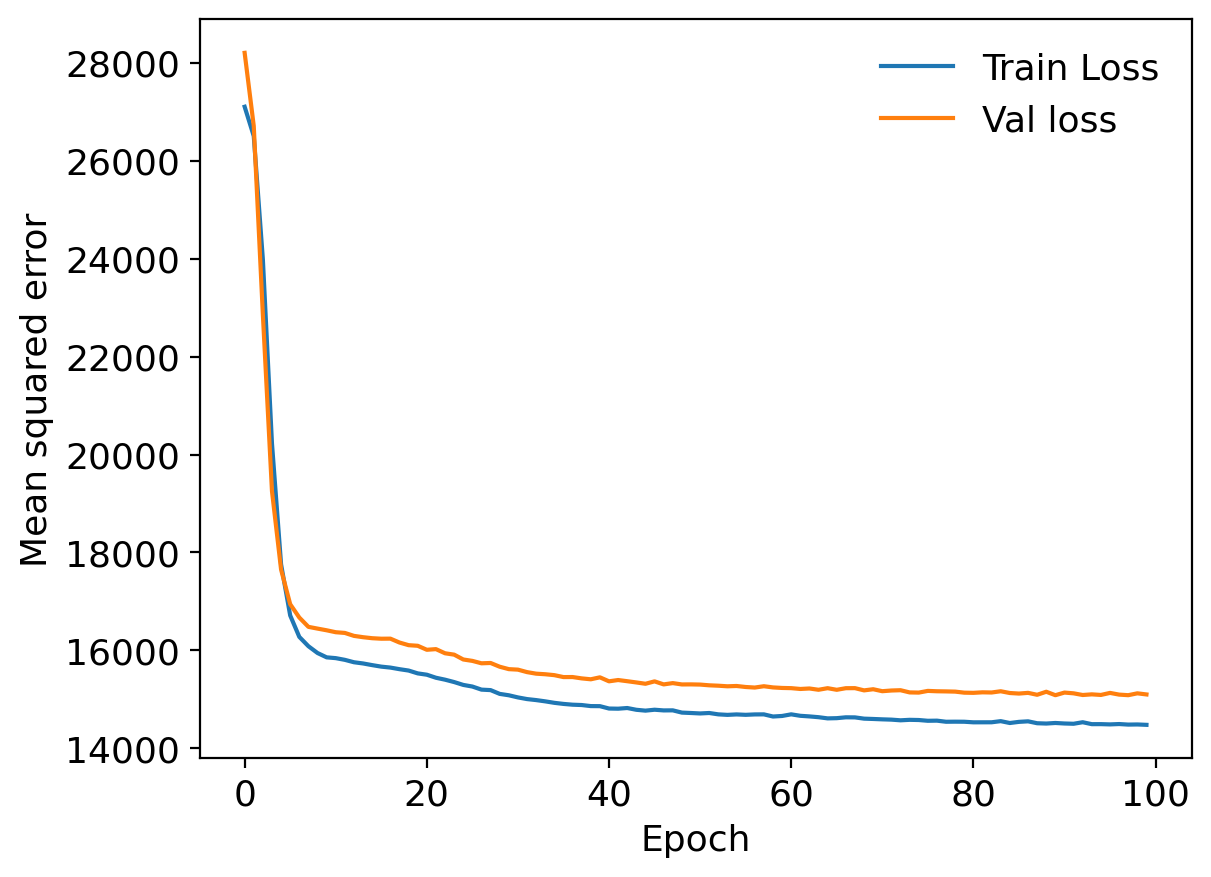

In [135]:
plot_history(history)

In [136]:
model_path = os.path.join(cwd,'saved_model')
make_dir(model_path)

In [137]:
# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
model.save(os.path.join(model_path,'CNN_model_1_member.h5'))

In [138]:
# reload the saved model
model = load_model(os.path.join(model_path,'CNN_model_1_member.h5'))

In [139]:
y_test_pre = model.predict(X_test)


1/1 [==============================] - 0s 339ms/step


In [140]:
y_test_pre_rs = y_test_pre.reshape(y_test_df.shape[0],y_test_df.shape[1],y_test_df.shape[2])

y_test_pre_xr = xr.Dataset(coords={'time': X_test_df.index.values, 
                               'x': y_array.x.values, 
                               'y': y_array.y.values},
                       data_vars=dict(velbar_mag=(['time', 'x', 'y'], y_test_pre_rs)))

In [141]:
y_test_pre_xr

<xarray.Dataset>
Dimensions:     (time: 25, x: 381, y: 381)
Coordinates:
  * time        (time) float64 -5.1e+04 -1.6e+04 -1.16e+05 ... -9.1e+04 -7.7e+04
  * x           (x) float64 -3.04e+06 -3.024e+06 ... 3.024e+06 3.04e+06
  * y           (y) float64 -3.04e+06 -3.024e+06 ... 3.024e+06 3.04e+06
Data variables:
    velbar_mag  (time, x, y) float32 1.033 1.198 1.198 1.198 ... 1.45 1.45 1.117

In [142]:
y_true = xr.Dataset(coords={'time': X_test_df.index.values, 
                               'x': y_array.x.values, 
                               'y': y_array.y.values},
                       data_vars=dict(velbar_mag=(['time', 'x', 'y'], y_test_df)))

In [143]:
y_true

<xarray.Dataset>
Dimensions:     (time: 25, x: 381, y: 381)
Coordinates:
  * time        (time) float64 -5.1e+04 -1.6e+04 -1.16e+05 ... -9.1e+04 -7.7e+04
  * x           (x) float64 -3.04e+06 -3.024e+06 ... 3.024e+06 3.04e+06
  * y           (y) float64 -3.04e+06 -3.024e+06 ... 3.024e+06 3.04e+06
Data variables:
    velbar_mag  (time, x, y) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0

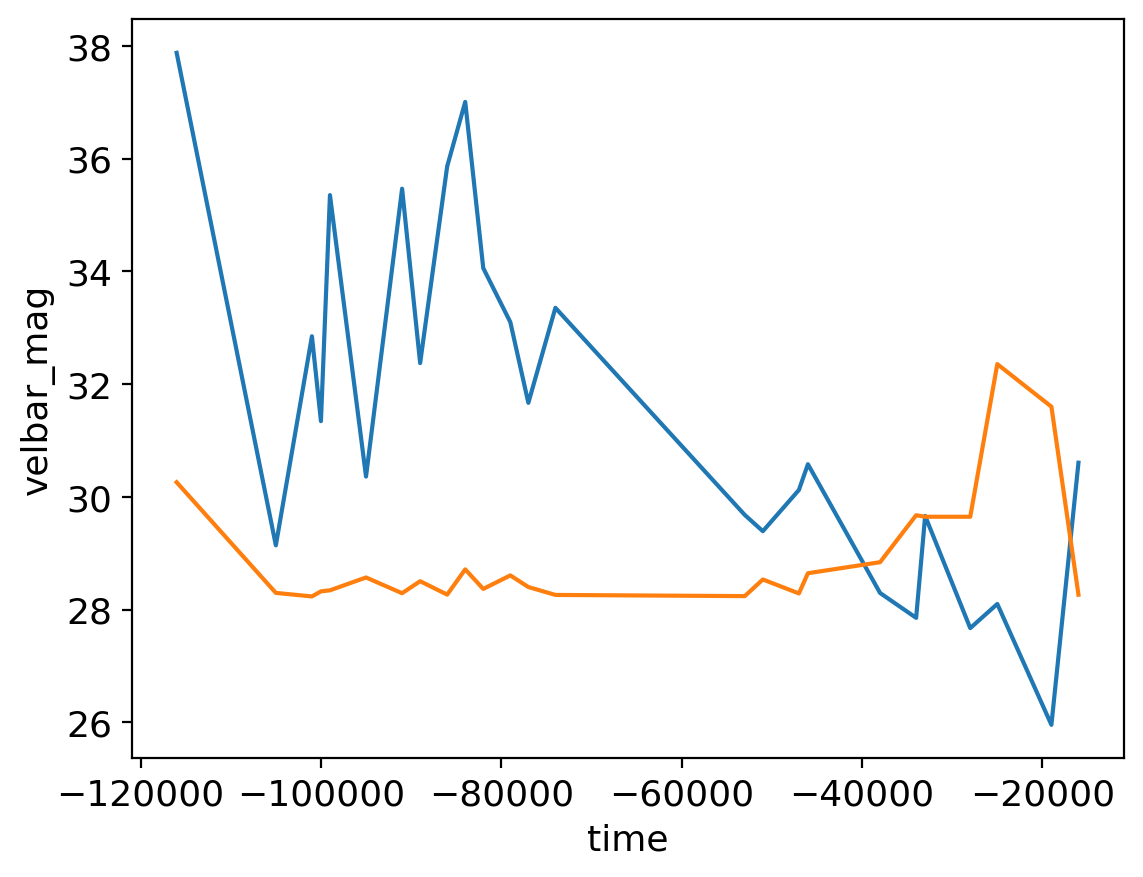

In [144]:
y_true.velbar_mag.sortby(y_true.time).mean(dim=['x','y']).plot()
y_test_pre_xr.velbar_mag.sortby(y_test_pre_xr.time).mean(dim=['x','y']).plot()

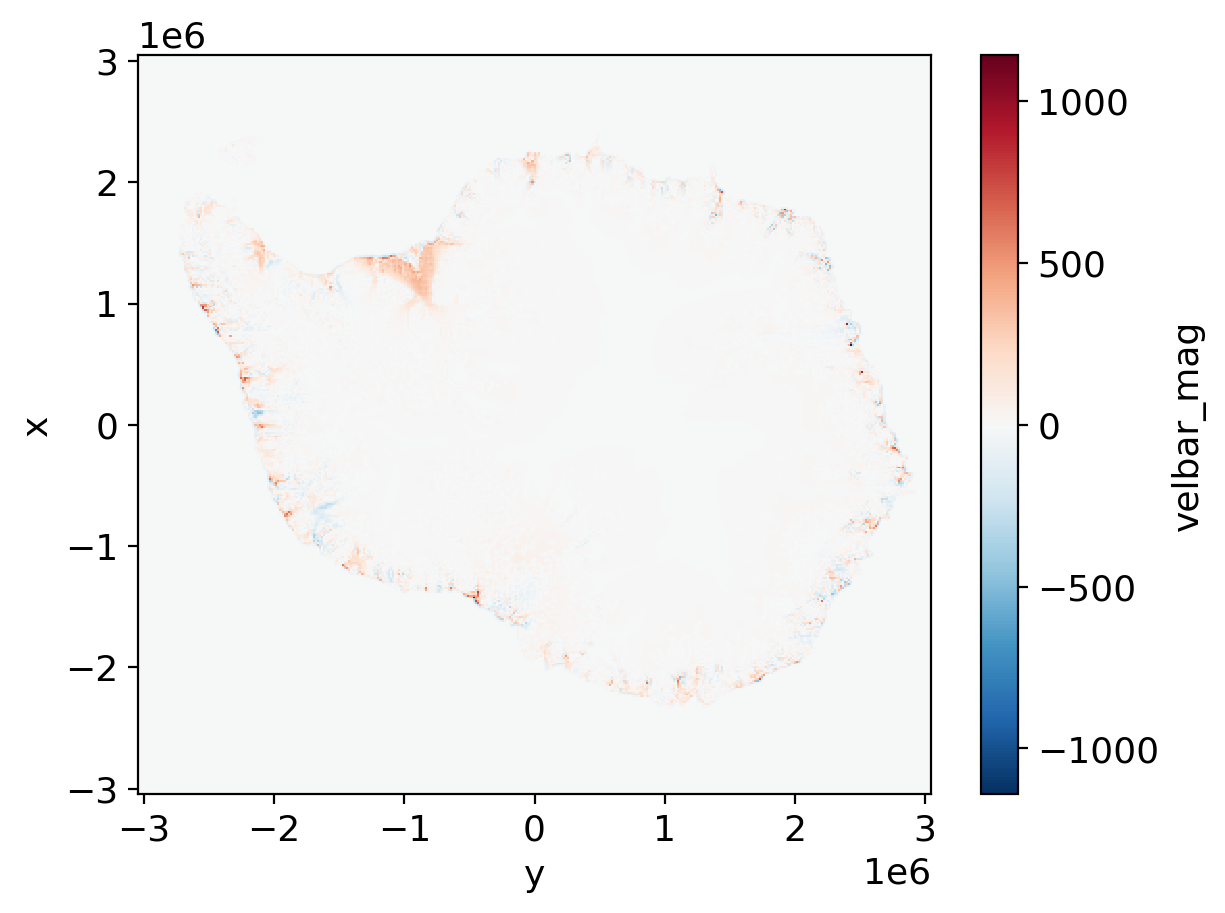

In [145]:
(y_true.velbar_mag-y_test_pre_xr.velbar_mag).mean(dim='time').plot()

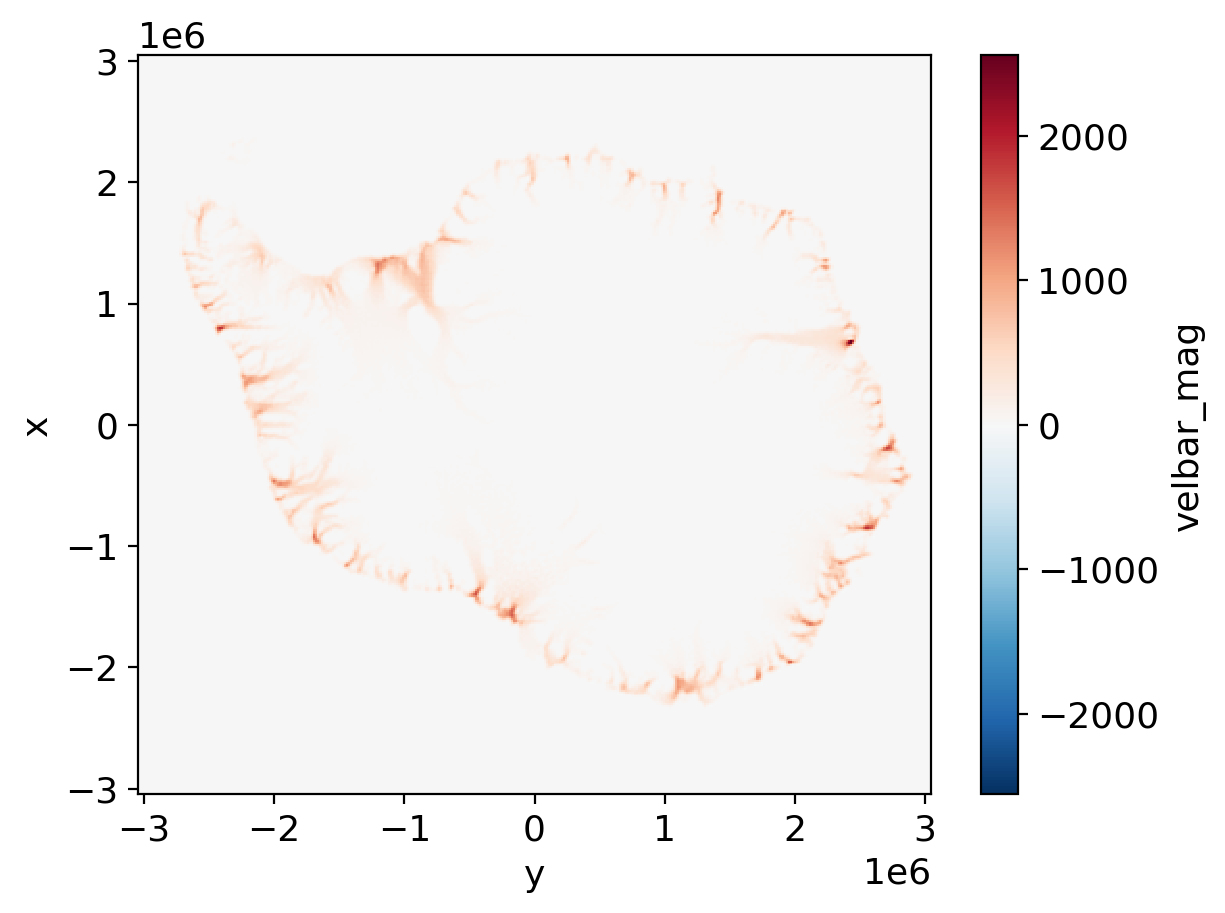

In [146]:
y_test_pre_xr.velbar_mag.mean(dim='time').plot()

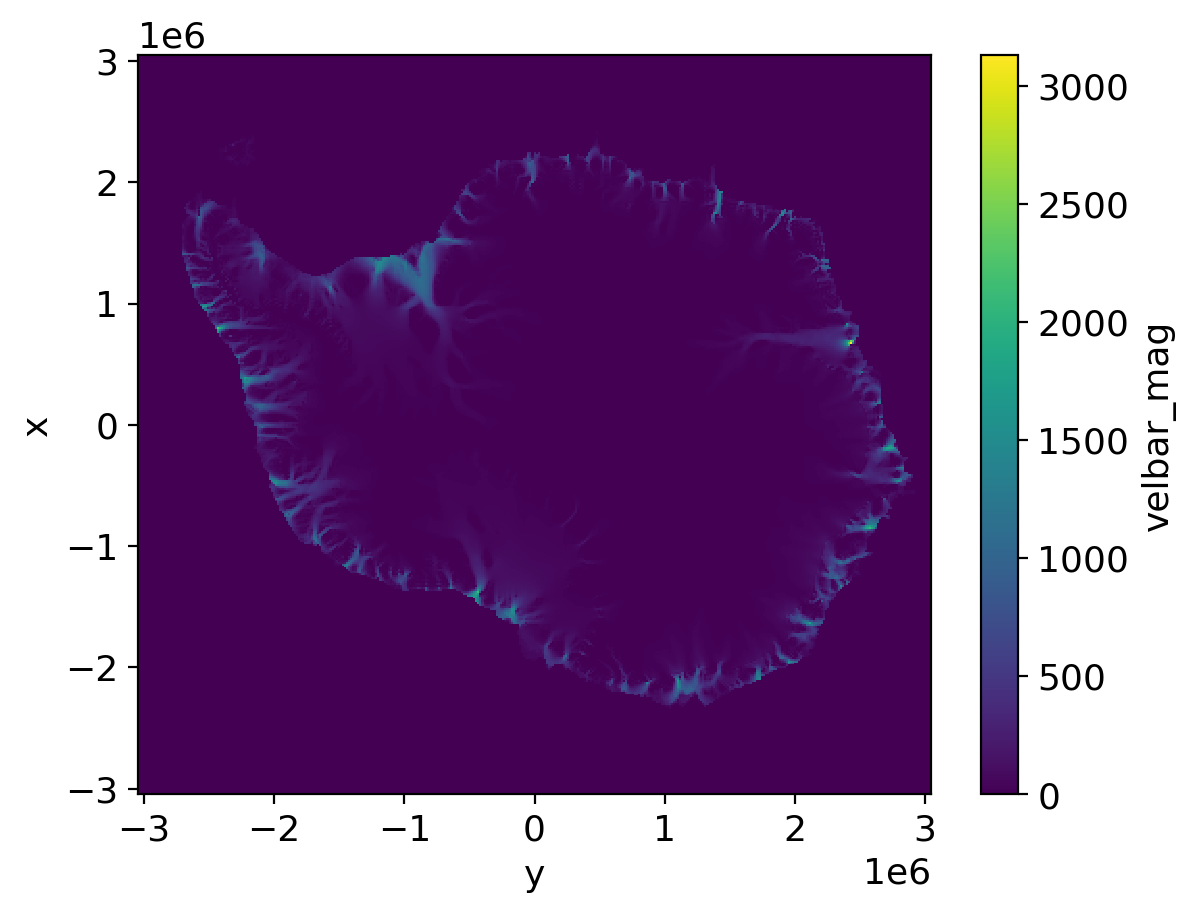

In [147]:
y_true.velbar_mag.mean(dim='time').plot()